In [129]:
import numpy as np
import cv2 as cv
from PIL import Image as PILImage
from typing import TypeAlias, Literal

In [130]:
NPArray: TypeAlias = np.ndarray
Image: TypeAlias = np.ndarray
MatcherType = Literal['bf', 'custom']

def read_image(path: str) -> Image:
	return cv.imread(path)


def display_image(img: Image, gray=False, title=None) -> None:
	if title:
		print(title)

	display(PILImage.fromarray(cv.cvtColor(img, cv.COLOR_BGR2RGB)))


def grayscale(img: Image) -> Image:
	return cv.cvtColor(img, cv.COLOR_BGR2GRAY)


def get_top_bf_matches(descriptors1: NPArray, descriptors2: NPArray, n: int = 20) -> list[cv.DMatch]:
	bf_matcher = cv.BFMatcher(cv.NORM_HAMMING)
	matches = bf_matcher.match(descriptors1, descriptors2)

	return sorted(matches, key=lambda x: x.distance)[:n]


def get_top_custom_matches(descriptors1: NPArray, descriptors2: NPArray, n: int = 20) -> list[cv.DMatch]:
	matches = [
		cv.DMatch(
		_distance=cv.norm(d1, d2, normType=cv.NORM_HAMMING),
		_imgIdx=0,
		_queryIdx=i,
		_trainIdx=j)
		for i, d1 in enumerate(descriptors1) for j, d2 in enumerate(descriptors2)
	]

	return sorted(matches, key=lambda x: x.distance)[:n]


def get_akaze_results(img1: Image, img2: Image) -> tuple[NPArray, NPArray, NPArray, NPArray]:
	akaze = cv.AKAZE_create()

	keypoints1, descriptors1 = akaze.detectAndCompute(img1, None)
	keypoints2, descriptors2 = akaze.detectAndCompute(img2, None)

	return keypoints1, descriptors1, keypoints2, descriptors2


def get_matched_image(
		img1: Image,
		img2: Image,
		descriptors1: NPArray,
		keypoints1: NPArray,
		descriptors2: NPArray,
		keypoints2: NPArray,
		matcher_type: MatcherType = 'bf',
) -> Image:
	matches = None

	if matcher_type == 'custom':
		matches = get_top_custom_matches(descriptors1, descriptors2)
	else:
		matches = get_top_bf_matches(descriptors1, descriptors2)

	return cv.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)


def compare_images(path1: str, path2: str, title1: str, title2: str) -> None:
	image1 = read_image(path1)
	image1_grayscale = grayscale(image1)

	display_image(image1, title=title1)

	image2 = read_image(path2)
	image2_grayscale = grayscale(image2)

	display_image(image2, title=title2)

	keypoints1, descriptors1, keypoints2, descriptors2 = get_akaze_results(image1_grayscale, image2_grayscale)

	image1_keypoints = cv.drawKeypoints(image1, keypoints1, None)
	display_image(image1_keypoints, title=f'Keypoints for {title1}')

	image2_keypoints = cv.drawKeypoints(image2, keypoints2, None)
	display_image(image2_keypoints, title=f'Keypoints for {title2}')

	image_matcher_bf = get_matched_image(image1, image2, descriptors1, keypoints1, descriptors2, keypoints2, 'bf')
	display_image(image_matcher_bf, title=f'Brute force matcher')

	image_matcher_custom = get_matched_image(image1, image2, descriptors1, keypoints1, descriptors2, keypoints2, 'custom')
	display_image(image_matcher_custom, title=f'Custom matcher')

Statue of liberty


Statue of liberty (rotated)


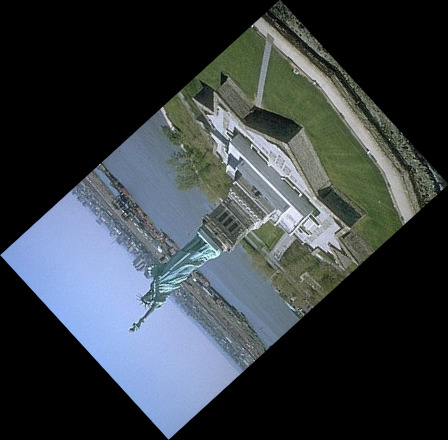

Keypoints for Statue of liberty


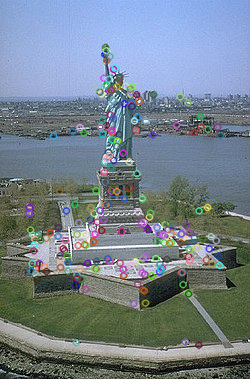

Keypoints for Statue of liberty (rotated)


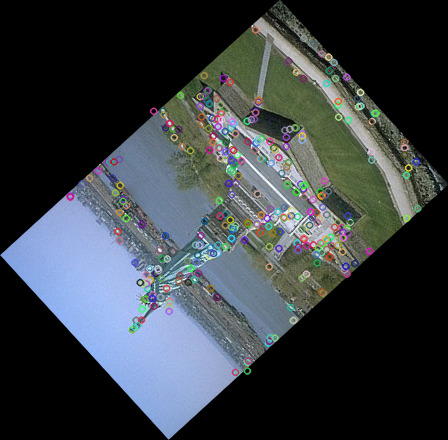

Brute force matcher


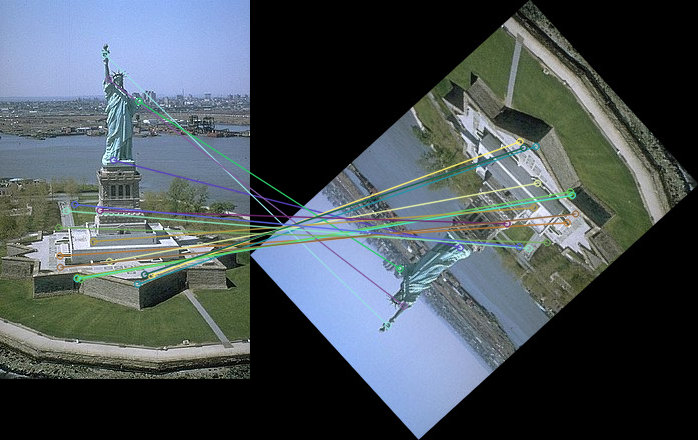

Custom matcher


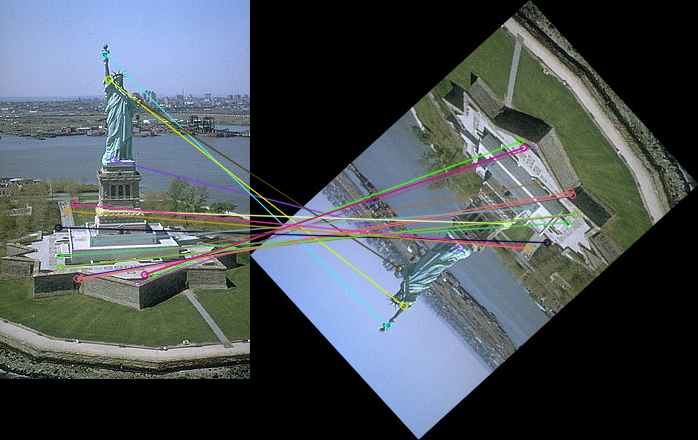

In [131]:
compare_images('liberty1.jpg','liberty2.jpg', 'Statue of liberty', 'Statue of liberty (rotated)')

Mazda


Mazda (other angle)


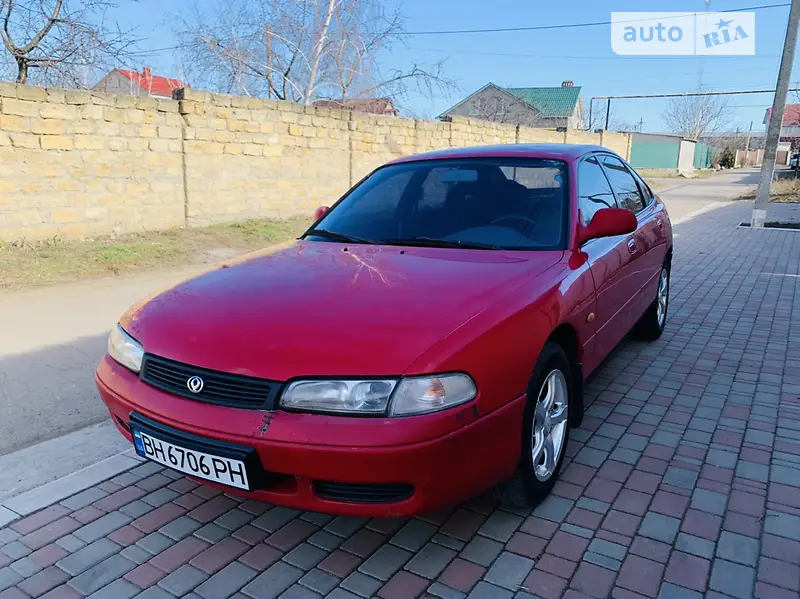

Keypoints for Mazda


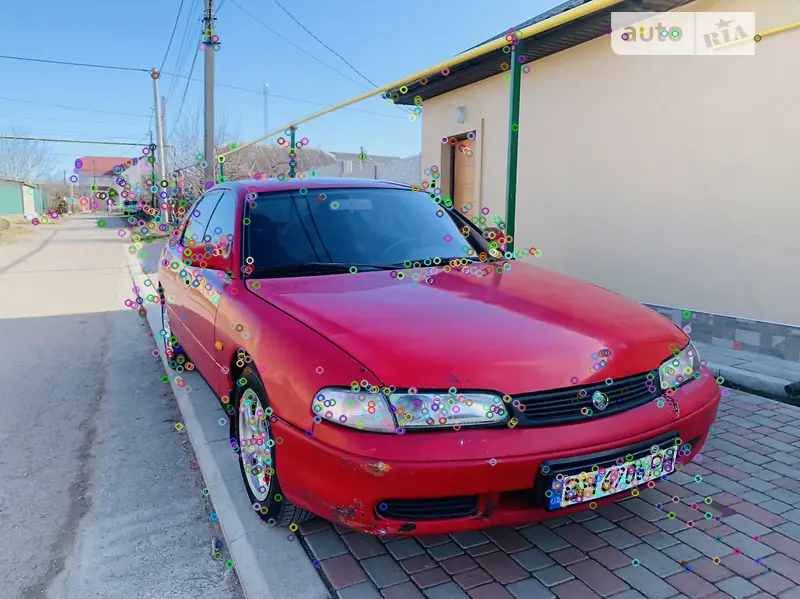

Keypoints for Mazda (other angle)


Brute force matcher


Custom matcher


In [133]:
compare_images('mazda1.webp','mazda2.webp', 'Mazda', 'Mazda (other angle)')